Competition Link: https://datahack.analyticsvidhya.com/contest/practice-problem-recommendation-engine

Recommendation Engine

Recommending the questions that a programmer should solve given his/her current expertise is a big challenge for Online Judge Platforms but is an essential task to keep a programmer engaged on their platform.

In this practice problem, you are given the data of programmers and questions that they have previously solved along with the time that they took to solve that particular question.

As a data scientist, your task is to build a model that can predict the time taken to solve a problem given the user current status.

This model will help online judges to decide the next level of questions to recommend to a user.

In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
#read data into dataframes
user_df = pd.read_csv(r'data/train/user_data.csv')
problem_df = pd.read_csv(r'data/train/problem_data.csv')
train_submussion_df = pd.read_csv(r'data/train/train_submissions.csv')
test_submussion_df = pd.read_csv(r'data/test_submissions.csv')

In [3]:
#lets look at the sample data for each of the data frame. Sample data for user data
user_df.head()

,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_3311,47,40,0,NaN,4,1504111645,348.337,330.849,intermediate,1466686436
1,user_3028,63,52,0,India,17,1498998165,405.677,339.450,intermediate,1441893325
2,user_2268,226,203,-8,Egypt,24,1505566052,307.339,284.404,beginner,1454267603
3,user_480,611,490,1,Ukraine,94,1505257499,525.803,471.330,advanced,1350720417
4,user_650,504,479,12,Russia,4,1496613433,548.739,486.525,advanced,1395560498


In [4]:
#description of user data
user_df.describe()

,submission_count,problem_solved,contribution,follower_count,last_online_time_seconds,max_rating,rating,registration_time_seconds
count,3571.000000,3571.000000,3571.000000,3571.000000,3.571000e+03,3571.000000,3571.000000,3.571000e+03
mean,299.481098,267.894427,4.102492,46.690563,1.502680e+09,390.374392,350.165578,1.434961e+09
std,366.102887,344.139688,16.552256,211.494638,5.114850e+06,92.428788,106.592503,4.750758e+07
min,1.000000,0.000000,-64.000000,0.000000,1.484237e+09,303.899000,0.000000,1.264761e+09
25%,66.500000,53.000000,0.000000,4.000000,1.502691e+09,317.661000,279.243000,1.416323e+09
50%,169.000000,146.000000,0.000000,13.000000,1.505054e+09,355.791000,329.702000,1.449085e+09
75%,390.000000,349.000000,0.000000,40.000000,1.505551e+09,444.954000,413.417500,1.470379e+09
max,4570.000000,4476.000000,171.000000,10575.000000,1.505595e+09,983.085000,911.124000,1.484236e+09


In [5]:
#count of null values
user_df.isna().sum()

user_id                         0
submission_count                0
problem_solved                  0
contribution                    0
country                      1153
follower_count                  0
last_online_time_seconds        0
max_rating                      0
rating                          0
rank                            0
registration_time_seconds       0
dtype: int64

In [6]:
#percentage of null values
user_df.isnull().mean()

user_id                      0.000000
submission_count             0.000000
problem_solved               0.000000
contribution                 0.000000
country                      0.322879
follower_count               0.000000
last_online_time_seconds     0.000000
max_rating                   0.000000
rating                       0.000000
rank                         0.000000
registration_time_seconds    0.000000
dtype: float64

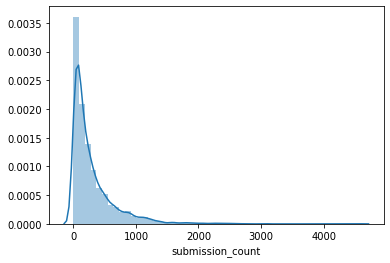

In [7]:
#plotting submision counts
sns.distplot(user_df["submission_count"])

In [8]:
#plotting problem solved counts
user_df['submission_count'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

0.1     25.0
0.2     52.0
0.3     84.0
0.4    120.0
0.5    169.0
0.6    236.0
0.7    329.0
0.8    473.0
0.9    747.0
Name: submission_count, dtype: float64

In [9]:
#creating bins for submission counts
submission_count_bins = pd.qcut(user_df["submission_count"], 4,labels = False)

#creating the new column for quantiled submission count
user_df["submission_count_bins"] = submission_count_bins.values

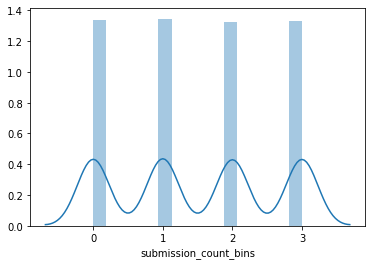

In [10]:
#Let's have a look at the distribution for submission count bins
sns.distplot(user_df["submission_count_bins"])

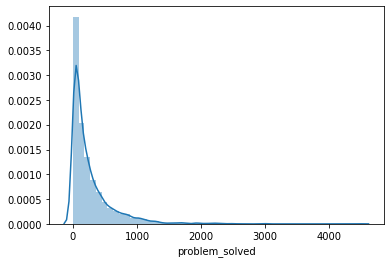

In [11]:
#plotting problem solved counts
sns.distplot(user_df["problem_solved"])

In [12]:
#plotting problem solved counts
user_df['problem_solved'].quantile([.2, .4,.6, .8])

0.2     40.0
0.4    100.0
0.6    207.0
0.8    422.0
Name: problem_solved, dtype: float64

In [13]:
#quantiling the problem solved counts
problem_solved_bins = pd.qcut(user_df["problem_solved"], 5,labels = False)

#creating bins for problem solved counts
user_df["problem_solved_bins"] = problem_solved_bins.values

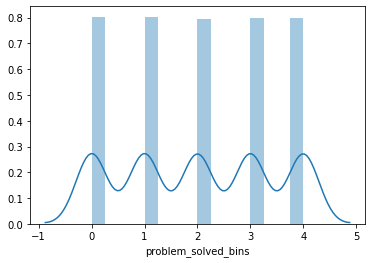

In [14]:
#let's look at the distribution of the problem solved bins
sns.distplot(user_df["problem_solved_bins"])

In [15]:
#let's have a look at the new column for problem solved bins
user_df.head()

,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds,submission_count_bins,problem_solved_bins
0,user_3311,47,40,0,NaN,4,1504111645,348.337,330.849,intermediate,1466686436,0,0
1,user_3028,63,52,0,India,17,1498998165,405.677,339.450,intermediate,1441893325,0,1
2,user_2268,226,203,-8,Egypt,24,1505566052,307.339,284.404,beginner,1454267603,2,2
3,user_480,611,490,1,Ukraine,94,1505257499,525.803,471.330,advanced,1350720417,3,4
4,user_650,504,479,12,Russia,4,1496613433,548.739,486.525,advanced,1395560498,3,4


In [16]:
#looks like problem solved count bins and submission count bins are identical. So I will check them once if they are idential
user_df['submission_count_bins'].equals(user_df['problem_solved_bins'])

False

submission_count_bins and problem_solved_bins are not identical so we can proceed with the other columns

In [17]:
#define success rate as a column
user_df['success_rate'] = user_df['problem_solved']/user_df['submission_count']*100

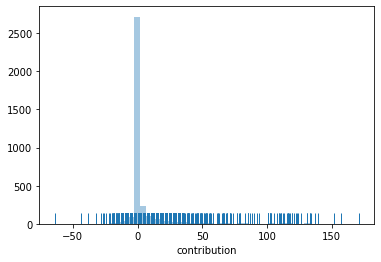

In [18]:
#Let's look at the distribution of the contribution
sns.distplot(user_df["contribution"], kde=False, rug=True)

In [19]:
#this is quite skewed with 2530 values as 0
user_df["contribution"].value_counts(normalize = True).head(10)

 0    0.708485
 1    0.032204
 2    0.018482
 3    0.016522
-1    0.012602
 4    0.010641
 6    0.010361
 5    0.009521
-2    0.007561
 7    0.007281
Name: contribution, dtype: float64

We will have to remove the fiels contribution as it has 70% values as 0

In [20]:
#Now let's look at the number of countries or values
user_df["country"].unique().shape

(80,)

Strategy for imputing the null values will be based on the ratio of occurence of the countries in the rest of the data.
For example, India occured 25.6% and Bangladesh occured 13.6% and so on. We will use this ratio of all the countries to fill the missing data.

In [21]:
#Getting all the ratios
country_data = (user_df["country"].value_counts()/user_df["country"].count())

In [22]:
#imputing missing values
user_df["country"]= user_df["country"].fillna(pd.Series(np.random.choice(country_data.index,p=country_data.values, size=len(user_df))))

Country is a categorical feature and there are 79 levels. I would like to keep the levels to 10. So, I will keep the first 9 countries by count and the rest of the countries will be put under "other"

In [23]:
country_list = user_df['country'].value_counts().index[:9]
user_df['country_new'] = np.where(user_df['country'].isin(country_list), user_df['country'], 'Other')

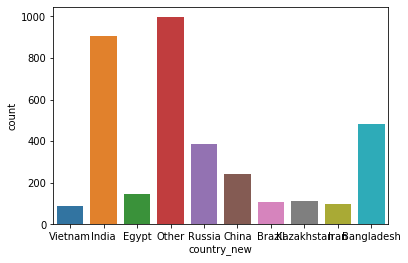

In [24]:
#Now let's look at the countries distribution
sns.countplot(user_df["country_new"])

In [25]:
#value counts of new field
user_df["country_new"].value_counts()

Other         996
India         906
Bangladesh    483
Russia        388
China         241
Egypt         144
Kazakhstan    114
Brazil        110
Iran           99
Vietnam        90
Name: country_new, dtype: int64

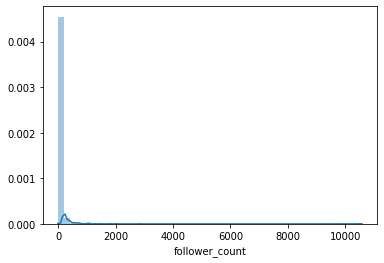

In [26]:
#plotting follower_count
sns.distplot(user_df["follower_count"])

In [27]:
user_df.loc[user_df["follower_count"]==0].shape

(327, 15)

In [28]:
#quantiling the follower_count
user_df['follower_count'].quantile([.2, .4, .6, .8])

0.2     2.0
0.4     9.0
0.6    21.0
0.8    50.0
Name: follower_count, dtype: float64

In [29]:
#creating bins for submission counts
follower_count_bins = pd.qcut(user_df["follower_count"], 5,labels = False)
#creating the new column for quantiled submission count
user_df["follower_count_bins"] = follower_count_bins.values

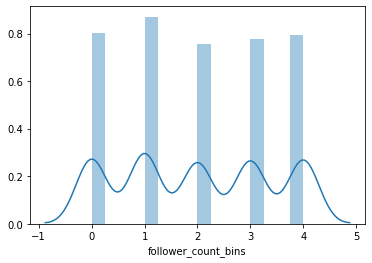

In [30]:
#Let's have a look at the new distribution
sns.distplot(user_df["follower_count_bins"])

In [31]:
#let's find the age of the user in the platform in months
user_df["age_in_platform"] = (user_df["last_online_time_seconds"] - user_df["registration_time_seconds"])/(24*3600*30)

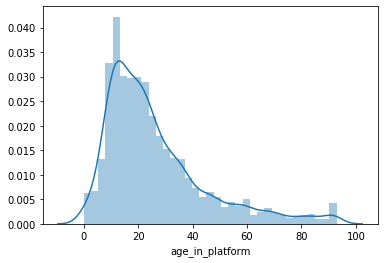

In [32]:
sns.distplot(user_df["age_in_platform"])

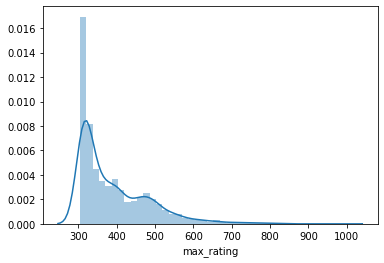

In [33]:
#plotting max_rating
sns.distplot(user_df["max_rating"])

In [34]:
#creating bins for max_rating counts
max_rating_bins = pd.qcut(user_df["max_rating"], 4,labels = False)

In [35]:
#creating the new column for quantiled max_rating count
user_df["max_rating_bins"] = max_rating_bins.values

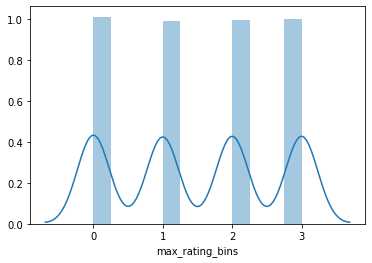

In [36]:
#plotting max_rating counts
sns.distplot(user_df["max_rating_bins"])

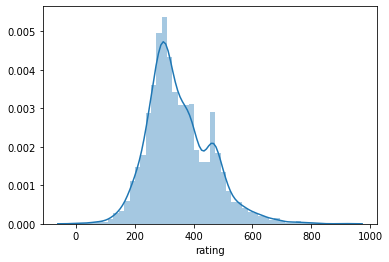

In [37]:
#plotting submision counts
sns.distplot(user_df["rating"])

In [38]:
#Now let's look at the unique ranks
user_df["rank"].unique()

array(['intermediate', 'beginner', 'advanced', 'expert'], dtype=object)

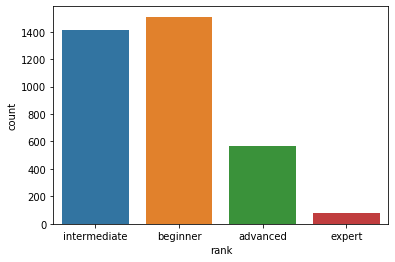

In [39]:
#Now let's look at the rank distribution
sns.countplot(user_df["rank"])

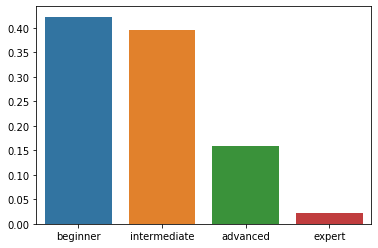

In [40]:
#Percentage distribution of rank
sns.barplot(user_df["rank"].value_counts(normalize = True).index, user_df["rank"].value_counts(normalize = True).values)

In [41]:
#percentage distribution of rank. It looks good to go
user_df["rank"].value_counts(normalize = True)

beginner        0.422571
intermediate    0.394847
advanced        0.159619
expert          0.022963
Name: rank, dtype: float64

In [42]:
user_df.columns

Index(['user_id', 'submission_count', 'problem_solved', 'contribution',
       'country', 'follower_count', 'last_online_time_seconds', 'max_rating',
       'rating', 'rank', 'registration_time_seconds', 'submission_count_bins',
       'problem_solved_bins', 'success_rate', 'country_new',
       'follower_count_bins', 'age_in_platform', 'max_rating_bins'],
      dtype='object')

In [43]:
#70% values are 0, so we can drop this field
user_df.drop(columns = ["contribution"],axis = 1, inplace = True)

In [44]:
#drop country as we have a new field for country with 'Other'
user_df.drop(columns = ["country"],axis = 1, inplace = True)

In [45]:
#registration time in year
user_df["registration_time"] = 2020.37158 - (user_df["registration_time_seconds"]/(3600*24*365)+1970)

In [46]:
#registration time in year
user_df["last_online_time"] = 2020.37158 - (user_df["last_online_time_seconds"]/(3600*24*365)+1970)

In [47]:
#drop last_online_time_seconds and registration_time_seconds as we have new fields for them
user_df.drop(columns = ["last_online_time_seconds","registration_time_seconds"],axis = 1, inplace = True)

In [48]:
#change values of country_new using a label encoder
labelencoder = LabelEncoder()
user_df['country_new'] = labelencoder.fit_transform(user_df['country_new'])

In [49]:
#change values of rank to numeric
rank_dict = {'beginner':0, 'intermediate':1, 'advanced':2, 'expert':3}
user_df["rank"] = user_df["rank"].apply(lambda x: rank_dict[x])

In [50]:
user_df.head()

,user_id,submission_count,problem_solved,follower_count,max_rating,rating,rank,submission_count_bins,problem_solved_bins,success_rate,country_new,follower_count_bins,age_in_platform,max_rating_bins,registration_time,last_online_time
0,user_3311,47,40,4,348.337,330.849,1,0,0,85.106383,9,1,14.438738,1,3.863258,2.676513
1,user_3028,63,52,17,405.677,339.450,1,0,1,82.539683,4,2,22.031188,2,4.649443,2.838660
2,user_2268,226,203,24,307.339,284.404,0,2,2,89.823009,3,3,19.791068,0,4.257057,2.630394
3,user_480,611,490,94,525.803,471.330,2,3,4,80.196399,7,4,59.620788,3,7.540517,2.640178
4,user_650,504,479,4,548.739,486.525,2,3,4,95.039683,8,1,38.986472,3,6.118647,2.914279


Let's look at the problem data now

In [51]:
problem_df = pd.read_csv(r'data/train/problem_data.csv')

In [52]:
#lets look at the sample data for problem data.
problem_df.head()

,problem_id,level_type,points,tags
0,prob_3649,H,NaN,NaN
1,prob_6191,A,NaN,NaN
2,prob_2020,F,NaN,NaN
3,prob_313,A,500.0,"greedy,implementation"
4,prob_101,A,500.0,"constructive algorithms,greedy,math"


In [53]:
#let's look at the null values and the shape of the problem data
print(problem_df.shape)
print(problem_df.isna().sum())
print(problem_df.isna().mean())

(6544, 4)
problem_id       0
level_type     133
points        3917
tags          3484
dtype: int64
problem_id    0.000000
level_type    0.020324
points        0.598564
tags          0.532396
dtype: float64


In [54]:
#let's look at the distribution of the level type
problem_df.level_type.value_counts()

A    1042
B    1017
C     915
D     850
E     795
F     421
G     328
H     272
I     256
J     212
K     154
L      99
M      40
N      10
Name: level_type, dtype: int64

In [55]:
#let's look at the distribution of the level type
problem_df.level_type.value_counts(normalize = True)

A    0.162533
B    0.158634
C    0.142723
D    0.132585
E    0.124006
F    0.065668
G    0.051162
H    0.042427
I    0.039931
J    0.033068
K    0.024021
L    0.015442
M    0.006239
N    0.001560
Name: level_type, dtype: float64

In [56]:
#I will fill up the values based on the ratio of distribution
#Getting all the ratios
level_type_data = (problem_df["level_type"].value_counts()/problem_df["level_type"].count())

#imputing missing values
problem_df["level_type_new"]= problem_df["level_type"].fillna(pd.Series(np.random.choice(level_type_data.index,p=level_type_data.values, size=len(problem_df))))

In [57]:
#Now I will have to label the level_type_new field
level_type_dict = {'A':0, 'B':1, 'C':2, 'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13}
problem_df["level_type_new"] = problem_df["level_type_new"].apply(lambda x: level_type_dict[x])

In [58]:
print(problem_df["points"].mean())
print(problem_df["points"].mode())
print(problem_df["points"].median())

1452.3818043395509
0    500.0
dtype: float64
1500.0


In [59]:
#imputing missing points values
problem_df["points"]= problem_df["points"].fillna(problem_df["points"].mean())
#I will fill up the values based on the ratio of distribution
#Getting all the ratios
#points_data = (problem_df["points"].value_counts()/problem_df["points"].count())

#imputing missing values for points
#problem_df["points"]= problem_df["points"].fillna(pd.Series(np.random.choice(points_data.index,p=points_data.values, size=len(problem_df))))

In [60]:
#I will remove level_type as there is a new field for that. tags should be removed as they have more than 50% null values
problem_df.drop(columns = ["level_type","tags"],axis = 1, inplace = True)

In [61]:
problem_df.head()

,problem_id,points,level_type_new
0,prob_3649,1452.381804,7
1,prob_6191,1452.381804,0
2,prob_2020,1452.381804,5
3,prob_313,500.000000,0
4,prob_101,500.000000,0


In [62]:
train_submussion_df.head()

,user_id,problem_id,attempts_range
0,user_232,prob_6507,1
1,user_3568,prob_2994,3
2,user_1600,prob_5071,1
3,user_2256,prob_703,1
4,user_2321,prob_356,1


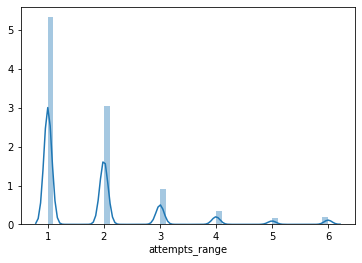

In [63]:
#let's look at the distribution of the attempts range
sns.distplot(train_submussion_df["attempts_range"])

In [64]:
train_submussion_df["attempts_range"].value_counts(normalize = True)

1    0.533205
2    0.304710
3    0.091072
4    0.035410
6    0.019531
5    0.016073
Name: attempts_range, dtype: float64

In [65]:
#merge train submission and user data
train_df = pd.merge(train_submussion_df,user_df,how = 'left',on = "user_id")
test_df = pd.merge(test_submussion_df,user_df,how = 'left',on = "user_id")

In [66]:
#merge train data and problem data
train_df = pd.merge(train_df,problem_df,how = 'left',on = "problem_id")
test_df = pd.merge(test_df,problem_df,how = 'left',on = "problem_id")

In [67]:
#create ID field for train data, ID already there for test data
train_df["ID"] = train_df["user_id"] + train_df["problem_id"]

In [68]:
train_df.head()

,user_id,problem_id,attempts_range,submission_count,problem_solved,follower_count,max_rating,rating,rank,submission_count_bins,...,success_rate,country_new,follower_count_bins,age_in_platform,max_rating_bins,registration_time,last_online_time,points,level_type_new,ID
0,user_232,prob_6507,1,53,47,1,307.913,206.709,0,0,...,88.679245,0,0,27.593689,0,4.959640,2.691666,1000.0,1,user_232prob_6507
1,user_3568,prob_2994,3,133,118,0,324.255,235.378,0,1,...,88.721805,7,0,18.339394,1,4.244474,2.737127,1500.0,2,user_3568prob_2994
2,user_1600,prob_5071,1,50,44,7,343.177,229.358,0,0,...,88.000000,7,1,12.048098,1,3.647491,2.657236,500.0,0,user_1600prob_5071
3,user_2256,prob_703,1,271,233,40,436.927,399.083,1,2,...,85.977860,7,3,22.159904,2,4.464152,2.642790,500.0,0,user_2256prob_703
4,user_2321,prob_356,1,155,135,80,492.546,472.190,2,1,...,87.096774,4,4,26.117744,3,4.781630,2.634966,2000.0,3,user_2321prob_356


In [69]:
test_df.head()

,ID,user_id,problem_id,submission_count,problem_solved,follower_count,max_rating,rating,rank,submission_count_bins,problem_solved_bins,success_rate,country_new,follower_count_bins,age_in_platform,max_rating_bins,registration_time,last_online_time,points,level_type_new
0,user_856_prob_5822,user_856,prob_5822,274,231,35,393.062,362.959,1,2,3,84.306569,4,3,31.277303,2,5.275083,2.704345,1452.381804,11
1,user_2642_prob_2334,user_2642,prob_2334,124,114,8,307.053,146.502,0,1,2,91.935484,4,1,25.299704,0,4.709804,2.630377,500.000000,0
2,user_2557_prob_2920,user_2557,prob_2920,367,283,76,321.674,241.399,0,2,3,77.111717,0,4,42.214172,1,6.099427,2.629769,500.000000,0
3,user_1572_prob_4598,user_1572,prob_4598,203,181,29,473.050,454.989,1,2,2,89.162562,7,3,31.399209,3,5.282734,2.701978,1000.000000,1
4,user_295_prob_6139,user_295,prob_6139,113,89,3,455.275,448.108,1,1,1,78.761062,7,1,15.541807,3,4.257380,2.979971,500.000000,0


In [70]:
#user_id count - number of times user is appearing
train_df['user_id_count'] = train_df.groupby('user_id')['user_id'].transform('count')
test_df['user_id_count'] = train_df.groupby('user_id')['user_id'].transform('count')

In [71]:
#problem_id count - number of times problem is appearing
train_df['problem_id_count'] = train_df.groupby('problem_id')['problem_id'].transform('count')
test_df['problem_id_count'] = train_df.groupby('problem_id')['problem_id'].transform('count')

In [72]:
#user id min attempts
train_df['user_id_min_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('min')
test_df['user_id_min_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('min')

In [73]:
#user id max attempts
train_df['user_id_max_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('max')
test_df['user_id_max_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('max')

In [74]:
#user id mean attempts
train_df['user_id_mean_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('mean')
test_df['user_id_mean_attempts'] = train_df.groupby('user_id')['attempts_range'].transform('mean')

In [75]:
#problem id min attempts
train_df['problem_id_min_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('min')
test_df['problem_id_min_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('min')

In [76]:
#problem id max attempts
train_df['problem_id_max_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('max')
test_df['problem_id_max_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('max')

In [77]:
#problem id mean attempts
train_df['problem_id_mean_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('mean')
test_df['problem_id_mean_attempts'] = train_df.groupby('problem_id')['attempts_range'].transform('mean')

In [78]:
#user id min level
train_df['user_id_min_level'] = train_df.groupby('user_id')['level_type_new'].transform('min')
test_df['user_id_min_level'] = train_df.groupby('user_id')['level_type_new'].transform('min')

In [79]:
#user id max level
train_df['user_id_max_level'] = train_df.groupby('user_id')['level_type_new'].transform('max')
test_df['user_id_max_level'] = train_df.groupby('user_id')['level_type_new'].transform('max')

In [80]:
#user id mean level
train_df['user_id_mean_level'] = train_df.groupby('user_id')['level_type_new'].transform('mean')
test_df['user_id_mean_level'] = train_df.groupby('user_id')['level_type_new'].transform('mean')

In [81]:
train_df['country_percent'] = train_df.groupby('country_new')['country_new'].transform('count')/len(train_df)
test_df['country_percent'] = train_df.groupby('country_new')['country_new'].transform('count')/len(train_df)

In [82]:
print(train_df.columns.shape)
print(test_df.columns.shape)

(33,)
(32,)


In [83]:
train_df.to_csv(r'data/train/train_df_fullfeature.csv', index=False)
test_df.to_csv(r'data/train/test_df_fullfeature.csv', index=False)

In [84]:
train_df_ff = pd.read_csv(r'data/train/train_df_fullfeature.csv')
test_df_ff = pd.read_csv(r'data/train/test_df_fullfeature.csv')

In [85]:
print(train_df_ff.columns.shape)
print(test_df_ff.columns.shape)

(33,)
(32,)


In [86]:
#define X
X = train_df_ff.drop(columns=['user_id','problem_id','ID','attempts_range'],axis=1)

In [87]:
#define y
y = train_df_ff["attempts_range"]

In [88]:
#split training data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [89]:
xgbC = XGBClassifier(colsample_bytree= 0.8, gamma= 2,learning_rate= 0.05,max_depth= 10,min_child_weight= 3,n_estimators= 300,objective= "multi:softprob",subsample= 0.8)
#xgbC = XGBClassifier(n_estimators= 300)

In [90]:
xgbC.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [91]:
y_test_pred = xgbC.predict(X_test)

In [92]:
accuracy_score(y_test, y_test_pred)

0.5843035235936535

In [93]:
f1_score(y_test, y_test_pred, average='weighted')

0.5430746182551953

In [94]:
#use random forest regressor
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=5, min_samples_leaf=100)

In [95]:
#fit the model
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
y_test_pred = xgbC.predict(X_test)

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.5843035235936535

In [98]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_pred, average='weighted')

0.5430746182551953